## Things noticed:
###	1. The time span for different datasets are different
		a. Subway --( 2010 May - 2018 May)
		b. Yellow Taxi -- (2009 Jan - 2017 Dec)
		c. Green Taxi -- (2013 Aug - 2017 Dec)
		d. FHV -- (2015 Jan - 2017 Dec)
###	2. Green taxi data in 2013 is quite biased. The number of riderships in 2013 is very low compared to the other years can be a result of a new service. We should only consider the data from 2014-2017
###	3. Yellow Taxi data is really big, like 2G for each month, need more time to process the data. 
###	4. For FHV data, many records did not come with taxi zone LocationID, so we might not take this dataset into account
###	5. For both Yellow and Green, coordinates info is available before 2017. After 2017 Jan, only taxi zone Location ID is available. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import geopandas as gpd
from shapely.geometry import Point
import fiona
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Read Taxi Data

In [3]:
yellow17_12 = pd.read_csv('https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-12.csv')

In [4]:
yellow17_1 = pd.read_csv('https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-01.csv')

In [5]:
green17_12 = pd.read_csv('https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2017-12.csv')
green17_1 = pd.read_csv('https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2017-01.csv')

In [8]:
yellow17_1.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount'],
      dtype='object')

In [9]:
yellow17_1 = yellow17_1[['passenger_count', 'PULocationID', 'DOLocationID']]
yellow17_12 = yellow17_12[['passenger_count', 'PULocationID', 'DOLocationID']]

In [12]:
green17_1 = green17_1[['passenger_count', 'PULocationID', 'DOLocationID']]
green17_12 = green17_12[['passenger_count', 'PULocationID', 'DOLocationID']]

## Groupby Taxi Zones

In [18]:
yel_pu1 = yellow17_1.groupby('PULocationID').passenger_count.sum()
yel_do1 = yellow17_1.groupby('DOLocationID').passenger_count.sum()
gre_pu1 = green17_1.groupby('PULocationID').passenger_count.sum()
gre_do1 = green17_1.groupby('DOLocationID').passenger_count.sum()

yel_pu12 = yellow17_12.groupby('PULocationID').passenger_count.sum()
yel_do12 = yellow17_12.groupby('DOLocationID').passenger_count.sum()
gre_pu12 = green17_12.groupby('PULocationID').passenger_count.sum()
gre_do12 = green17_12.groupby('DOLocationID').passenger_count.sum()

In [52]:
df1 = pd.DataFrame(data={'yel_pu1':yel_pu1,'yel_do1':yel_do1})
df2 = pd.DataFrame(data={'yel_pu12':yel_pu12,'yel_do12':yel_do12})
df3 = pd.DataFrame(data={'gre_pu1':gre_pu1,'gre_do1':gre_do1})
df4 = pd.DataFrame(data={'gre_pu12':gre_pu12,'gre_do12':gre_do12})

In [66]:
df12 = df1.merge(df2, how='outer', left_index=True, right_index=True)
df34 = df3.merge(df4, how='outer', left_index=True, right_index=True)
df = df12.merge(df34, how='outer', left_index=True, right_index=True)

In [68]:
df = df.fillna(0)

In [71]:
df['pickup1'] = df.yel_pu1 + df.gre_pu1
df['pickup12'] = df.yel_pu12 + df.gre_pu12
df['dropoff1'] = df.yel_do1 + df.gre_do1
df['dropoff12'] = df.yel_do12 + df.gre_do12

In [73]:
df = df.reset_index()

In [76]:
df.columns = ['LocationID', 'yel_do1', 'yel_pu1', 'yel_do12', 'yel_pu12', 'gre_do1',
       'gre_pu1', 'gre_do12', 'gre_pu12', 'pickup1', 'pickup12', 'dropoff1',
       'dropoff12']

In [77]:
df_ = df[['LocationID', 'pickup1', 'pickup12', 'dropoff1','dropoff12']]

## Read Taxi zone file

In [115]:
taxi_zones = gpd.read_file('taxi_zones/taxi_zones.shp')

In [116]:
taxi = pd.merge(taxi_zones,df_)

In [117]:
taxi['pu_change'] = np.log(taxi.pickup12)/np.log(taxi.pickup1)
taxi['do_change'] = np.log(taxi.dropoff12)/np.log(taxi.dropoff1)

Text(0.5,1,'Yellow and Green Taxi Riderships in 2017 Dec \n by Taxi Zones')

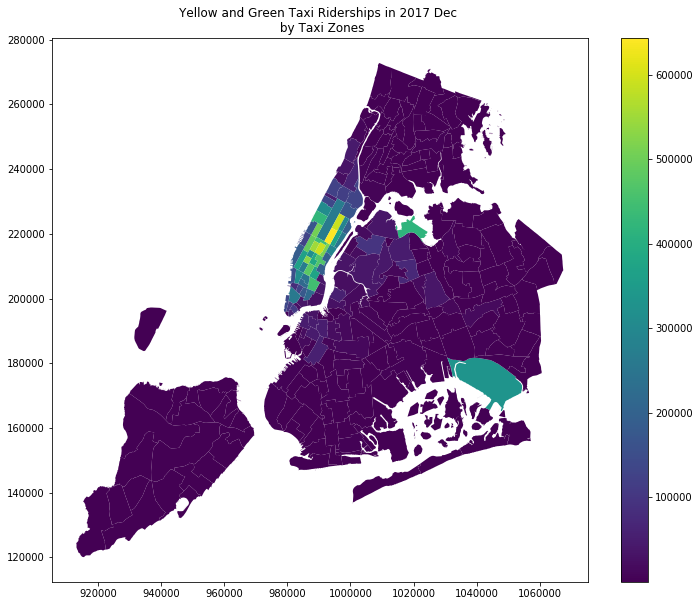

In [123]:
f, ax = plt.subplots(figsize=(12,10))
taxi.plot(ax=ax, column = 'pickup12',legend=True);
plt.title('Yellow and Green Taxi Riderships in 2017 Dec \n by Taxi Zones')

Text(0.5,1,'Yellow and Green Taxi Riderships change between During 2017 \n by Taxi Zones')

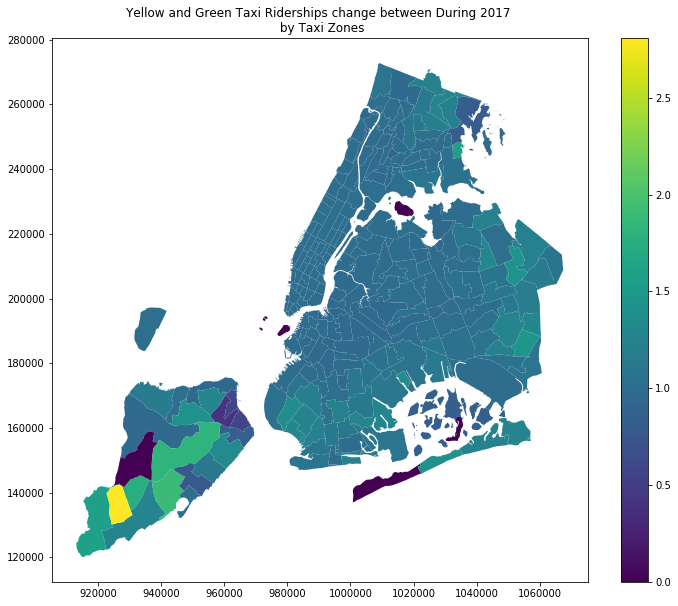

In [121]:
f, ax = plt.subplots(figsize=(12,10))
taxi.plot(ax=ax, column = 'pu_change',legend=True);
plt.title('Yellow and Green Taxi Riderships change between During 2017 \n by Taxi Zones')